# Import Libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib


import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')



# Get Data

In [4]:
df = pd.read_csv("/content/drive/MyDrive/MY_PROJECTS/fraud-detection-system/Fraud.csv")

In [5]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
df.shape

(6362620, 11)

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08
isFraud,6362620.0,1.290820e-03,3.590480e-02,0.0,0.00,0.000,0.000000e+00,1.000000e+00
isFlaggedFraud,6362620.0,2.514687e-06,1.585775e-03,0.0,0.00,0.000,0.000000e+00,1.000000e+00


In [8]:
df.describe(include='object').T

,count,unique,top,freq
type,6362620,5,CASH_OUT,2237500
nameOrig,6362620,6353307,C1530544995,3
nameDest,6362620,2722362,C1286084959,113


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [10]:
list(df.columns)

['step',
 'type',
 'amount',
 'nameOrig',
 'oldbalanceOrg',
 'newbalanceOrig',
 'nameDest',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'isFlaggedFraud']

In [11]:
df['isFraud'].value_counts()

,count
isFraud,
0,6354407
1,8213


In [12]:
df['isFlaggedFraud'].value_counts()

,count
isFlaggedFraud,
0,6362604
1,16


In [13]:
df.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


# EDA

In [14]:
round((df['isFraud'].value_counts()[1]/df.shape[0])*100, 3) # there is a class impalance

np.float64(0.129)

In [15]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

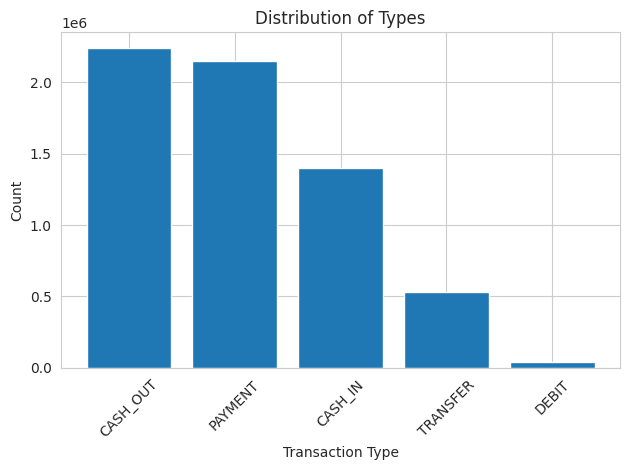

In [16]:
type_counts = df['type'].value_counts()

plt.bar(type_counts.index, type_counts.values)
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.title('Distribution of Types')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
fraud_by_type = df.groupby('type')['isFraud'].mean().sort_values(ascending=False)
fraud_by_type

,isFraud
type,
TRANSFER,0.007688
CASH_OUT,0.001840
CASH_IN,0.000000
DEBIT,0.000000
PAYMENT,0.000000


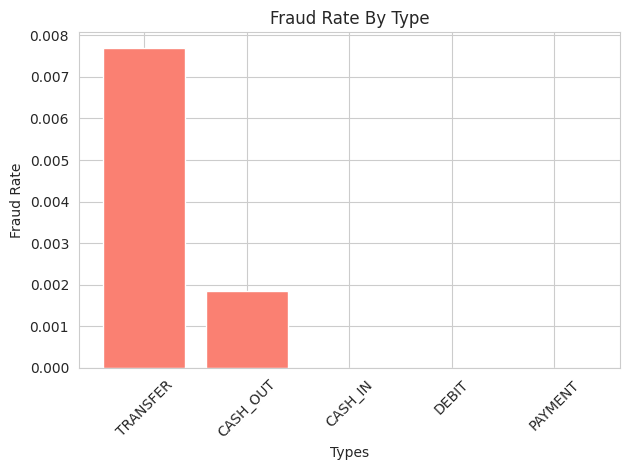

In [18]:
plt.bar(fraud_by_type.index, fraud_by_type.values, color="salmon")
plt.xlabel('Types')
plt.ylabel('Fraud Rate')
plt.title('Fraud Rate By Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
df['amount'].describe().astype(int)

,amount
count,6362620
mean,179861
std,603858
min,0
25%,13389
50%,74871
75%,208721
max,92445516


In [20]:
df['amount'].median()

74871.94

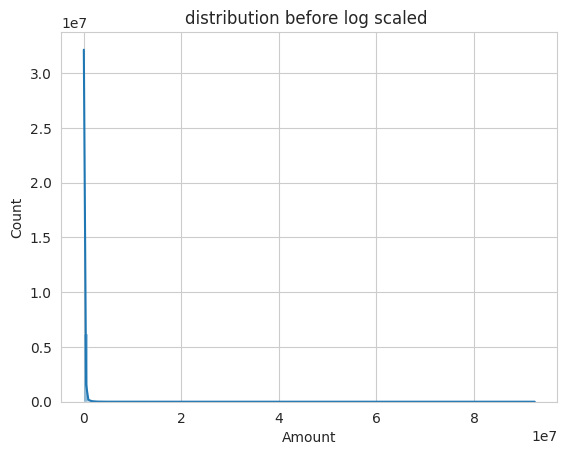

In [21]:
sns.histplot(df['amount'], bins = 100, kde = True)
plt.title("distribution before log scaled ")
plt.xlabel("Amount")
plt.show()

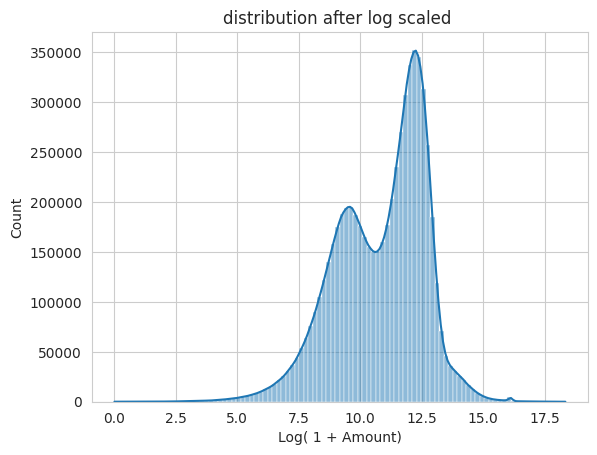

In [22]:
sns.histplot(np.log1p(df['amount']), bins = 100, kde = True)
plt.title("distribution after log scaled ")
plt.xlabel("Log( 1 + Amount)")
plt.show()

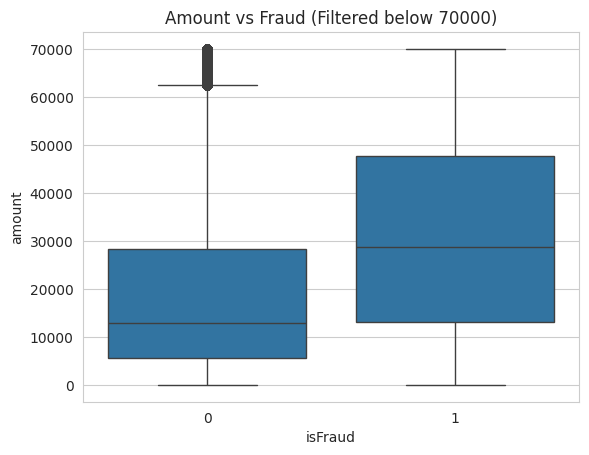

In [23]:
sns.boxplot(data = df[df['amount'] < 70000], x = 'isFraud', y = 'amount')
plt.title("Amount vs Fraud (Filtered below 70000)")
plt.show()

In [24]:
df['balanceDiffOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['balanceDiffDest'] = df['oldbalanceDest'] - df['newbalanceDest']

In [25]:
(df["balanceDiffOrig"]<0).sum()

np.int64(1399253)

In [26]:
(df["balanceDiffDest"]<0).sum()

np.int64(2806464)

In [27]:
df.head(2)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,9839.64,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1864.28,0.0


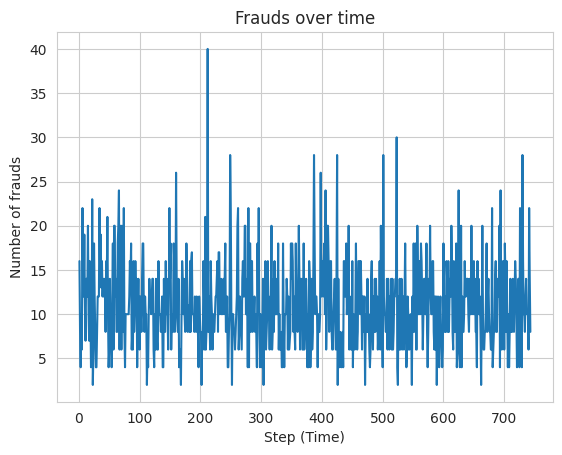

In [28]:
frauds_per_Step = df[df['isFraud'] == 1]['step'].value_counts().sort_index()

plt.plot(frauds_per_Step.index, frauds_per_Step.values, label = "fraud per step")
plt.title("Frauds over time")
plt.xlabel("Step (Time)")
plt.ylabel("Number of frauds")
plt.grid(True)
plt.show()
# we gain that it is time independent so let's drop it

In [29]:
df.drop(columns = 'step', inplace=True)

In [30]:
top_senders = df['nameOrig'].value_counts().head(10)
top_senders

,count
nameOrig,
C1530544995,3
C545315117,3
C724452879,3
C1784010646,3
C1677795071,3
C1462946854,3
C1065307291,3
C1999539787,3
C2098525306,3


In [31]:
top_recievers = df['nameDest'].value_counts().head(10)
top_recievers

,count
nameDest,
C1286084959,113
C985934102,109
C665576141,105
C2083562754,102
C248609774,101
C1590550415,101
C1789550256,99
C451111351,99
C1360767589,98


In [32]:
fraud_users = df[df['isFraud'] == 1]['nameDest'].value_counts().head(10)
fraud_users

,count
nameDest,
C1981613973,2
C410033330,2
C1366192319,2
C1655359478,2
C803116137,2
C52390890,2
C1325541393,2
C904300960,2
C2020337583,2


In [33]:
transfer_and_cash_out_df = df[df['type'].isin(['TRANSFER', 'CASH_OUT'])]

In [34]:
transfer_and_cash_out_df['type'].value_counts()

,count
type,
CASH_OUT,2237500
TRANSFER,532909


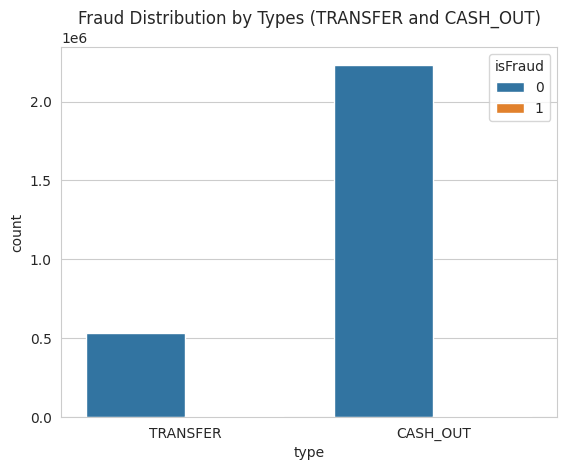

In [35]:
sns.countplot(data = transfer_and_cash_out_df, x ='type', hue = 'isFraud')
plt.title("Fraud Distribution by Types (TRANSFER and CASH_OUT)")
plt.show()

In [36]:
corr = df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud']].corr()

In [37]:
corr

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
amount,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688
oldbalanceOrg,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154
newbalanceOrig,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148
oldbalanceDest,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885
newbalanceDest,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535
isFraud,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000


Text(0.5, 1.0, 'Correlation Heatmap')

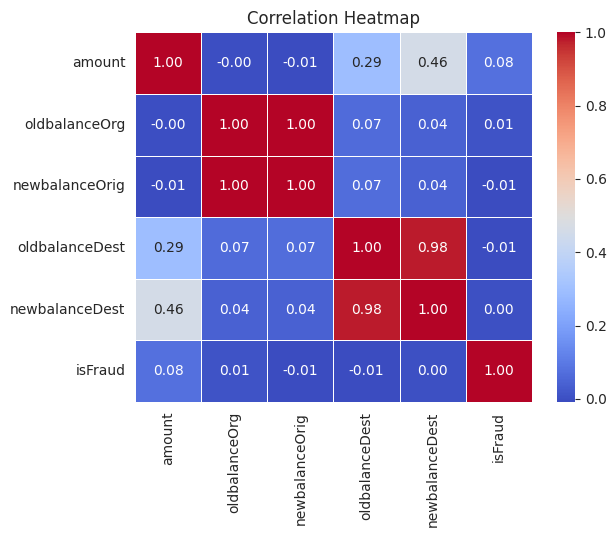

In [38]:
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap")

In [39]:
zero_after_transfer = df[
    (df['oldbalanceOrg'] > 0) &
    (df['newbalanceOrig'] == 0) &
    (df['type'].isin(['TRANSFER', 'CASH_OUT']))
]

In [40]:
len(zero_after_transfer)

1188074

In [41]:
zero_after_transfer.sample(5)

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
296300,CASH_OUT,744073.43,C1221365510,54341.00,0.0,C877878184,1069551.71,2007199.54,0,0,54341.00,-937647.83
6234680,CASH_OUT,37887.05,C317851198,36275.00,0.0,C1490043358,0.00,37887.05,0,0,36275.00,-37887.05
1644277,TRANSFER,930416.01,C1184991322,767864.00,0.0,C1788934225,156826.94,1087242.96,0,0,767864.00,-930416.02
5291995,CASH_OUT,129663.62,C627626821,547.00,0.0,C1840205805,0.00,129663.62,0,0,547.00,-129663.62
1133520,CASH_OUT,390141.12,C1126359762,237090.87,0.0,C1171960796,2158763.21,2548904.32,0,0,237090.87,-390141.11


# Modeling

In [42]:
df.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
0,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,9839.64,0.0
1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1864.28,0.0
2,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,181.00,0.0
3,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,181.00,21182.0
4,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,11668.14,0.0


In [43]:
df_modeling = df.drop(columns=['nameOrig', 'nameDest', 'isFlaggedFraud'])

In [44]:
df_modeling.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,balanceDiffOrig,balanceDiffDest
0,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,9839.64,0.0
1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,1864.28,0.0
2,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,181.00,0.0
3,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,181.00,21182.0
4,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,11668.14,0.0


In [45]:
cat = ['type']
num = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

In [46]:
x = df_modeling.drop(columns='isFraud')
y = df_modeling['isFraud']

In [47]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)

In [48]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num),
        ('cat', OneHotEncoder(), cat)
    ]
)

In [49]:
pipeline  = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'))
])

In [50]:
pipeline.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['amount', 'oldbalanceOrg',
                                                   'newbalanceOrig',
                                                   'oldbalanceDest',
                                                   'newbalanceDest']),
                                                 ('cat', OneHotEncoder(),
                                                  ['type'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

In [51]:
ypred = pipeline.predict(x_test)

In [52]:
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97   1906322
           1       0.02      0.94      0.04      2464

    accuracy                           0.95   1908786
   macro avg       0.51      0.94      0.51   1908786
weighted avg       1.00      0.95      0.97   1908786



In [53]:
pipeline.score(x_test, y_test)

0.9467064406381858

In [54]:
joblib.dump(pipeline, 'fraud_detection_model.pkl')

['fraud_detection_model.pkl']

In [55]:
# Create a sample transaction DataFrame
sample_transaction = pd.DataFrame({
    'type': ['CASH_OUT'],
    'amount': [1000.0],
    'oldbalanceOrg': [1000000000.0],
    'newbalanceOrig': [0],
    'oldbalanceDest': [0.0],
    'newbalanceDest': [1000.0],
})

# Load the saved pipeline
loaded_pipeline = joblib.load('fraud_detection_model.pkl')

# Make a prediction
prediction = loaded_pipeline.predict(sample_transaction)

if prediction[0] == 1:
    print("The transaction is predicted as fraudulent.")
else:
    print("The transaction is predicted as not fraudulent.")

The transaction is predicted as fraudulent.
